In [1]:
from ARRG_micro import *

In [2]:
class ObservableDataset(Dataset):
	"""
	Converts observable dataset into PyTorch syntax.
	"""
	def __init__(self, data):
		self.data = data

	def __len__(self):
		return self.data.shape[0]

	def __getitem__(self, idx):
		sample = self.data[idx]
		return sample

In [3]:
def a_b_grid(x_range, y_range, n_points):
    """
    Creates a grid of values within a two-dimensional range and returns it in a flattened tensor.

    Parameters:
    x_range (tuple): A tuple of (min, max) for the x-axis range.
    y_range (tuple): A tuple of (min, max) for the y-axis range.
    steps (int): --- The number of steps/points in each dimension.

    Returns:
    torch.Tensor: A flattened tensor containing all the grid points.
    """
    # Create linearly spaced points for each range
    x_points = torch.linspace(x_range[0], x_range[1], n_points)
    y_points = torch.linspace(y_range[0], y_range[1], n_points)

    # Create a meshgrid from the x and y points
    x_grid, y_grid = torch.meshgrid(x_points, y_points, indexing='ij')

    # Flatten the grid and stack the coordinates
    grid_flattened = torch.stack([x_grid.flatten(), y_grid.flatten()], dim=1)

    return grid_flattened

In [4]:
# Paths to the datasets on perlmutter
exp_hadrons_PATH = '../pgun_qqbar_finalTwo_hadrons_a_0.68_b_0.98_sigma_0.335_N_1e5.npy'
#exp_accept_reject_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_accept_reject_z_a_0.68_b_0.98_sigma_0.335_N_1e6.npy'
sim_hadrons_PATH = '../pgun_qqbar_finalTwo_hadrons_a_0.72_b_0.88_sigma_0.335_N_1e5.npy'
sim_accept_reject_PATH = '../pgun_qqbar_finalTwo_accept_reject_z_a_0.72_b_0.88_sigma_0.335_N_50e3.npy'
sim_fPrel_PATH = '../pgun_qqbar_finalTwo_fPrel_a_0.72_b_0.88_sigma_0.335_N_50e3.npy'

# Load the arrays
exp_hadrons       = np.load(exp_hadrons_PATH, mmap_mode="r")
sim_hadrons       = np.load(sim_hadrons_PATH, mmap_mode="r")
sim_accept_reject = np.load(sim_accept_reject_PATH, mmap_mode = "r")
sim_fPrel         = np.load(sim_fPrel_PATH, mmap_mode = "r")

# Print dataset shapes
print('Experimental hadrons shape:', exp_hadrons.shape)
print('Simulated hadrons shape:', sim_hadrons.shape)
print('Simulated z shape:', sim_accept_reject.shape)
print('Simulated fPrel shape:', sim_fPrel.shape)

# Restrict to a subset of the full dataset (for memory)
N_events = int(15000)

# Convert into torch objects
sim_hadron_flow   = torch.Tensor(sim_hadrons[0:N_events].copy())
sim_accept_reject = torch.Tensor(sim_accept_reject[0:N_events].copy())
sim_fPrel         = torch.Tensor(sim_fPrel[0:N_events].copy())
exp_hadron_flow   = torch.Tensor(exp_hadrons[0:N_events].copy())

# Check the accepted z-values, if z == 1 reduce it by epsilon (a very nasty bug to find).
# The a-coefficient when computing the likelihood has a term propotional to log(1-z). If 
# z = 1, this term diverges to -inf and completely destroys the backward pass.
epsilon = 1e-5
sim_accept_reject[sim_accept_reject == 1] = 1 - epsilon

# Print dataset shapes
print('Experimental multiplicity shape:', exp_hadron_flow.shape)
print('Simulated multiplicity shape:', sim_hadron_flow.shape)
print('Simulated z shape:', sim_accept_reject.shape)
print('Simulated fPrel shape:', sim_fPrel.shape)

# Prepare data for DataLoader
sim_hadron_flow   = ObservableDataset(sim_hadron_flow)
sim_accept_reject = ObservableDataset(sim_accept_reject)
sim_mT            = ObservableDataset(sim_fPrel)
exp_hadron_flow   = ObservableDataset(exp_hadron_flow)

Experimental hadrons shape: (100000, 75, 5)
Simulated hadrons shape: (100000, 75, 5)
Simulated z shape: (50000, 105, 101)
Simulated fPrel shape: (50000, 105, 100)
Experimental multiplicity shape: torch.Size([15000, 75, 5])
Simulated multiplicity shape: torch.Size([15000, 75, 5])
Simulated z shape: torch.Size([15000, 105, 101])
Simulated fPrel shape: torch.Size([15000, 105, 100])


In [5]:
print(exp_hadron_flow[0])

tensor([[-1.3050e-01,  5.3407e-01,  1.2875e+01,  1.2887e+01,  1.3957e-01],
        [ 1.3625e-01, -6.7473e-01,  1.4843e+01,  1.4860e+01,  1.3957e-01],
        [ 2.3702e-01,  1.1233e-01,  1.6519e+01,  1.6521e+01,  1.3498e-01],
        [ 1.9211e-02,  1.1466e-01,  2.4827e+00,  2.4894e+00,  1.3957e-01],
        [-5.1677e-01, -1.9544e-01,  1.9018e+00,  1.9850e+00,  1.3498e-01],
        [-1.9343e-01, -5.1813e-01, -1.1360e+01,  1.1374e+01,  1.3957e-01],
        [ 3.8620e-01, -1.8503e-01,  9.6767e-01,  1.0674e+00,  1.3957e-01],
        [ 2.1271e-01,  3.0126e-01, -6.7203e-01,  7.7917e-01,  1.3957e-01],
        [-2.3610e-01,  5.7475e-01, -1.7802e+00,  1.8907e+00,  1.3957e-01],
        [-3.0081e-03, -6.0890e-01, -2.3597e+00,  2.4407e+00,  1.3498e-01],
        [-1.9194e-01, -3.5481e-01, -1.2469e+00,  1.3179e+00,  1.3957e-01],
        [-4.6640e-02,  4.5368e-01, -9.0631e-01,  1.0235e+00,  1.3498e-01],
        [ 2.5689e-01,  8.0712e-01, -1.6802e+01,  1.6824e+01,  1.3957e-01],
        [ 0.0000e+00,  0.

In [6]:
# Set batch size -- set it eqaul to the number of events, we only want one 'batch'
batch_size = N_events

# Initialize data-loaders
sim_observable_dataloader    = DataLoader(sim_hadron_flow,   batch_size = batch_size, shuffle = False)
sim_accept_reject_dataloader = DataLoader(sim_accept_reject, batch_size = batch_size, shuffle = False)
sim_fPrel_dataloader         = DataLoader(sim_fPrel,         batch_size = batch_size, shuffle = False)
exp_observable_dataloader    = DataLoader(exp_hadron_flow,   batch_size = batch_size, shuffle = False)

In [7]:
print('Size of sim_observable_dataloader:', len(sim_observable_dataloader.dataset))
print('Size of sim_accept_reject_dataloader:', len(sim_accept_reject_dataloader.dataset))
print('Size of sim_fPrel_dataloader:', len(sim_fPrel_dataloader.dataset))
print('Size of exp_observable_dataloader:', len(exp_observable_dataloader.dataset))

Size of sim_observable_dataloader: 15000
Size of sim_accept_reject_dataloader: 15000
Size of sim_fPrel_dataloader: 15000
Size of exp_observable_dataloader: 15000


In [8]:
# Training hyperparameters
over_sample_factor = 10.0
# The flow map will be dependent on the learning rate
learning_rate = 0.01
fixed_binning = True
# Length of event buffer
dim_multiplicity  = sim_accept_reject_dataloader.dataset.data.shape[1]
dim_accept_reject = sim_accept_reject_dataloader.dataset.data.shape[2]

print('Each event has been zero-padded to a length of', dim_multiplicity)
print('Each emission has been zero-padded to a length of', dim_accept_reject)

# Define base parameters of simulated data (a, b)
params_base = torch.tensor([0.72, 0.88])
# Define a grid of initial parameters
a_range  = (0.6-0.1, 0.80+0.1)#(0.6, 0.80)
b_range  = (0.85-0.1, 1.05+0.1)#(0.85, 1.05)
n_points = 10
a_b_init = a_b_grid(a_range, b_range, n_points)

Each event has been zero-padded to a length of 105
Each emission has been zero-padded to a length of 101


In [9]:
print('Initial a_b grid shape:', a_b_init.shape)

Initial a_b grid shape: torch.Size([100, 2])


In [10]:
# Irrelevant parameters for the flow plot that must be initialized for the ARRG class
epochs = 1
learning_rate = 0.01

# Create an ARRG instance
ARRG = ARRG(epochs = epochs, dim_multiplicity = dim_multiplicity, dim_accept_reject = dim_accept_reject, over_sample_factor = over_sample_factor,
			params_base = params_base, sim_observable_dataloader = sim_observable_dataloader, sim_z_dataloader = sim_accept_reject_dataloader, 
			sim_fPrel_dataloader = sim_fPrel_dataloader, exp_observable_dataloader = exp_observable_dataloader, print_details = False, 
			results_dir = None, params_init = None, fixed_binning = True)

In [11]:
# Set the optimizer
optimizer = torch.optim.Adam(ARRG.weight_nexus.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(macroscopic_trainer.weight_nexus.parameters(), lr=learning_rate)

# Generate gradients!
a_b_gradients, loss_grid = ARRG.ARRG_flow(optimizer, a_b_init)

  0%|                                                                       | 0/100 [00:00<?, ?it/s]/global/homes/t/tmenzo/.conda/envs/py311/lib/python3.11/site-packages/ot/lp/__init__.py:580: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)
  1%|▋                                                              | 1/100 [00:31<52:30, 31.82s/it]

----------------------------------------------
Loss: 0.15250176
a: 0.5
Gradient of a: -1.5443392
b: 0.75
Gradient of b: 0.41493618
----------------------------------------------


  2%|█▎                                                             | 2/100 [01:03<52:13, 31.98s/it]

----------------------------------------------
Loss: 0.19004925
a: 0.5
Gradient of a: -3693.8345
b: 0.79444444
Gradient of b: 457.54553
----------------------------------------------


  3%|█▉                                                             | 3/100 [01:35<51:03, 31.59s/it]

----------------------------------------------
Loss: 0.23676918
a: 0.5
Gradient of a: -1.653852
b: 0.8388889
Gradient of b: 0.66548234
----------------------------------------------


  4%|██▌                                                            | 4/100 [02:04<49:28, 30.92s/it]

----------------------------------------------
Loss: 0.2925769
a: 0.5
Gradient of a: -1.8048054
b: 0.8833333
Gradient of b: 0.5566435
----------------------------------------------


  5%|███▏                                                           | 5/100 [02:34<48:12, 30.45s/it]

----------------------------------------------
Loss: 0.35037896
a: 0.5
Gradient of a: -4874.0547
b: 0.92777777
Gradient of b: 3747.6912
----------------------------------------------


  6%|███▊                                                           | 6/100 [03:04<47:19, 30.20s/it]

----------------------------------------------
Loss: 0.42277506
a: 0.5
Gradient of a: -3625.5564
b: 0.9722222
Gradient of b: 4846.0464
----------------------------------------------


  7%|████▍                                                          | 7/100 [03:33<46:27, 29.97s/it]

----------------------------------------------
Loss: 0.49543947
a: 0.5
Gradient of a: -14081.212
b: 1.0166667
Gradient of b: 14905.291
----------------------------------------------


  8%|█████                                                          | 8/100 [04:04<46:10, 30.11s/it]

----------------------------------------------
Loss: 0.5725539
a: 0.5
Gradient of a: -6686.3765
b: 1.0611111
Gradient of b: 7955.6226
----------------------------------------------


  9%|█████▋                                                         | 9/100 [04:33<45:16, 29.85s/it]

----------------------------------------------
Loss: 0.6457777
a: 0.5
Gradient of a: -39221.594
b: 1.1055555
Gradient of b: 40885.4
----------------------------------------------


 10%|██████▏                                                       | 10/100 [05:02<44:36, 29.74s/it]

----------------------------------------------
Loss: 0.7242904
a: 0.5
Gradient of a: -77802.89
b: 1.15
Gradient of b: 62980.242
----------------------------------------------


 11%|██████▊                                                       | 11/100 [05:33<44:30, 30.00s/it]

----------------------------------------------
Loss: 0.08783137
a: 0.54444444
Gradient of a: -0.29035577
b: 0.75
Gradient of b: -0.17243251
----------------------------------------------


 12%|███████▍                                                      | 12/100 [06:04<44:32, 30.37s/it]

----------------------------------------------
Loss: 0.09982455
a: 0.54444444
Gradient of a: -0.9121449
b: 0.79444444
Gradient of b: 0.25585067
----------------------------------------------


 13%|████████                                                      | 13/100 [06:34<43:52, 30.26s/it]

----------------------------------------------
Loss: 0.12720048
a: 0.54444444
Gradient of a: -0.97818285
b: 0.8388889
Gradient of b: 0.30879968
----------------------------------------------


 14%|████████▋                                                     | 14/100 [07:05<43:28, 30.33s/it]

----------------------------------------------
Loss: 0.16989544
a: 0.54444444
Gradient of a: -1.7695285
b: 0.8833333
Gradient of b: 0.8304056
----------------------------------------------


 15%|█████████▎                                                    | 15/100 [07:36<43:15, 30.53s/it]

----------------------------------------------
Loss: 0.21324486
a: 0.54444444
Gradient of a: -2.508901
b: 0.92777777
Gradient of b: 1.2152464
----------------------------------------------


 16%|█████████▉                                                    | 16/100 [08:05<42:22, 30.27s/it]

----------------------------------------------
Loss: 0.26927534
a: 0.54444444
Gradient of a: -1.7137482
b: 0.9722222
Gradient of b: 0.7209854
----------------------------------------------


 17%|██████████▌                                                   | 17/100 [08:36<42:11, 30.50s/it]

----------------------------------------------
Loss: 0.3353526
a: 0.54444444
Gradient of a: -2.9955492
b: 1.0166667
Gradient of b: 1.1754408
----------------------------------------------


 18%|███████████▏                                                  | 18/100 [09:06<41:16, 30.20s/it]

----------------------------------------------
Loss: 0.40170568
a: 0.54444444
Gradient of a: -3.4134414
b: 1.0611111
Gradient of b: 1.6211619
----------------------------------------------


 19%|███████████▊                                                  | 19/100 [09:35<40:21, 29.90s/it]

----------------------------------------------
Loss: 0.46982896
a: 0.54444444
Gradient of a: -186647.75
b: 1.1055555
Gradient of b: 216641.86
----------------------------------------------


 20%|████████████▍                                                 | 20/100 [10:05<39:41, 29.77s/it]

----------------------------------------------
Loss: 0.5417623
a: 0.54444444
Gradient of a: -439110.3
b: 1.15
Gradient of b: 299261.94
----------------------------------------------


 21%|█████████████                                                 | 21/100 [10:34<39:03, 29.67s/it]

----------------------------------------------
Loss: 0.09683008
a: 0.5888889
Gradient of a: 0.535692
b: 0.75
Gradient of b: -0.6051904
----------------------------------------------


 22%|█████████████▋                                                | 22/100 [11:04<38:46, 29.82s/it]

----------------------------------------------
Loss: 0.070754744
a: 0.5888889
Gradient of a: 0.7408212
b: 0.79444444
Gradient of b: -0.56431025
----------------------------------------------


 23%|██████████████▎                                               | 23/100 [11:34<38:18, 29.85s/it]

----------------------------------------------
Loss: 0.06371474
a: 0.5888889
Gradient of a: -0.46917582
b: 0.8388889
Gradient of b: 0.06311646
----------------------------------------------


 24%|██████████████▉                                               | 24/100 [12:05<38:05, 30.07s/it]

----------------------------------------------
Loss: 0.07856927
a: 0.5888889
Gradient of a: -0.96204543
b: 0.8833333
Gradient of b: 0.33119562
----------------------------------------------


 25%|███████████████▌                                              | 25/100 [12:36<37:53, 30.32s/it]

----------------------------------------------
Loss: 0.108292826
a: 0.5888889
Gradient of a: -1.2128056
b: 0.92777777
Gradient of b: 0.5595915
----------------------------------------------


 26%|████████████████                                              | 26/100 [13:07<37:37, 30.50s/it]

----------------------------------------------
Loss: 0.15034626
a: 0.5888889
Gradient of a: -2.1406393
b: 0.9722222
Gradient of b: 0.967553
----------------------------------------------


 27%|████████████████▋                                             | 27/100 [13:39<37:40, 30.97s/it]

----------------------------------------------
Loss: 0.20024352
a: 0.5888889
Gradient of a: -1.7179048
b: 1.0166667
Gradient of b: 0.73135424
----------------------------------------------


 28%|█████████████████▎                                            | 28/100 [14:09<36:54, 30.75s/it]

----------------------------------------------
Loss: 0.25021595
a: 0.5888889
Gradient of a: -291867.22
b: 1.0611111
Gradient of b: 103504.28
----------------------------------------------


 29%|█████████████████▉                                            | 29/100 [14:40<36:21, 30.73s/it]

----------------------------------------------
Loss: 0.31865367
a: 0.5888889
Gradient of a: -3079.1208
b: 1.1055555
Gradient of b: 4119.429
----------------------------------------------


 30%|██████████████████▌                                           | 30/100 [15:09<35:31, 30.45s/it]

----------------------------------------------
Loss: 0.38030362
a: 0.5888889
Gradient of a: -53894.484
b: 1.15
Gradient of b: 41452.66
----------------------------------------------


 31%|███████████████████▏                                          | 31/100 [15:40<35:06, 30.53s/it]

----------------------------------------------
Loss: 0.16548353
a: 0.6333333
Gradient of a: 1.9325371
b: 0.75
Gradient of b: -1.2847378
----------------------------------------------


 32%|███████████████████▊                                          | 32/100 [16:11<34:41, 30.61s/it]

----------------------------------------------
Loss: 0.112567745
a: 0.6333333
Gradient of a: 1.1581621
b: 0.79444444
Gradient of b: -0.8366268
----------------------------------------------


 33%|████████████████████▍                                         | 33/100 [16:41<34:06, 30.55s/it]

----------------------------------------------
Loss: 0.07253583
a: 0.6333333
Gradient of a: 0.7775035
b: 0.8388889
Gradient of b: -0.5229195
----------------------------------------------


 34%|█████████████████████                                         | 34/100 [17:12<33:35, 30.53s/it]

----------------------------------------------
Loss: 0.05028977
a: 0.6333333
Gradient of a: -0.10377919
b: 0.8833333
Gradient of b: -0.06644799
----------------------------------------------


 35%|█████████████████████▋                                        | 35/100 [17:42<33:05, 30.55s/it]

----------------------------------------------
Loss: 0.045512285
a: 0.6333333
Gradient of a: -0.3584491
b: 0.92777777
Gradient of b: 0.06374642
----------------------------------------------


 36%|██████████████████████▎                                       | 36/100 [18:13<32:30, 30.48s/it]

----------------------------------------------
Loss: 0.064146854
a: 0.6333333
Gradient of a: -0.5567602
b: 0.9722222
Gradient of b: 0.27019638
----------------------------------------------


 37%|██████████████████████▉                                       | 37/100 [18:42<31:41, 30.18s/it]

----------------------------------------------
Loss: 0.09675875
a: 0.6333333
Gradient of a: -0.45406976
b: 1.0166667
Gradient of b: 0.13633192
----------------------------------------------


 38%|███████████████████████▌                                      | 38/100 [19:13<31:22, 30.37s/it]

----------------------------------------------
Loss: 0.1377457
a: 0.6333333
Gradient of a: -1.8638566
b: 1.0611111
Gradient of b: 1.1397386
----------------------------------------------


 39%|████████████████████████▏                                     | 39/100 [19:44<31:14, 30.72s/it]

----------------------------------------------
Loss: 0.18464047
a: 0.6333333
Gradient of a: -3584.1462
b: 1.1055555
Gradient of b: 4183.51
----------------------------------------------


 40%|████████████████████████▊                                     | 40/100 [20:16<30:54, 30.91s/it]

----------------------------------------------
Loss: 0.2408566
a: 0.6333333
Gradient of a: -11857.646
b: 1.15
Gradient of b: 7633.158
----------------------------------------------


 41%|█████████████████████████▍                                    | 41/100 [20:46<30:16, 30.79s/it]

----------------------------------------------
Loss: 0.27570033
a: 0.67777777
Gradient of a: 1.8732387
b: 0.75
Gradient of b: -1.4336241
----------------------------------------------


 42%|██████████████████████████                                    | 42/100 [21:17<29:51, 30.88s/it]

----------------------------------------------
Loss: 0.2026254
a: 0.67777777
Gradient of a: 1.3751903
b: 0.79444444
Gradient of b: -0.7532405
----------------------------------------------


 43%|██████████████████████████▋                                   | 43/100 [21:47<28:58, 30.49s/it]

----------------------------------------------
Loss: 0.14222537
a: 0.67777777
Gradient of a: 1.2116464
b: 0.8388889
Gradient of b: -0.7396333
----------------------------------------------


 44%|███████████████████████████▎                                  | 44/100 [22:17<28:15, 30.29s/it]

----------------------------------------------
Loss: 0.09295497
a: 0.67777777
Gradient of a: 1.0964766
b: 0.8833333
Gradient of b: -0.5847579
----------------------------------------------


 45%|███████████████████████████▉                                  | 45/100 [22:47<27:51, 30.38s/it]

----------------------------------------------
Loss: 0.056365956
a: 0.67777777
Gradient of a: 0.33067766
b: 0.92777777
Gradient of b: -0.22232859
----------------------------------------------


 46%|████████████████████████████▌                                 | 46/100 [23:18<27:20, 30.39s/it]

----------------------------------------------
Loss: 0.03468412
a: 0.67777777
Gradient of a: 0.04243565
b: 0.9722222
Gradient of b: -0.09445875
----------------------------------------------


 47%|█████████████████████████████▏                                | 47/100 [23:49<26:55, 30.48s/it]

----------------------------------------------
Loss: 0.03509735
a: 0.67777777
Gradient of a: -0.54148185
b: 1.0166667
Gradient of b: 0.28198
----------------------------------------------


 48%|█████████████████████████████▊                                | 48/100 [24:19<26:29, 30.58s/it]

----------------------------------------------
Loss: 0.056157157
a: 0.67777777
Gradient of a: -0.95586264
b: 1.0611111
Gradient of b: 0.5286026
----------------------------------------------


 49%|██████████████████████████████▍                               | 49/100 [24:49<25:50, 30.41s/it]

----------------------------------------------
Loss: 0.09097989
a: 0.67777777
Gradient of a: -1.0420207
b: 1.1055555
Gradient of b: 0.54158103
----------------------------------------------


 50%|███████████████████████████████                               | 50/100 [25:20<25:20, 30.40s/it]

----------------------------------------------
Loss: 0.13292727
a: 0.67777777
Gradient of a: -5012.3584
b: 1.15
Gradient of b: 6688.052
----------------------------------------------


 51%|███████████████████████████████▌                              | 51/100 [25:51<24:59, 30.60s/it]

----------------------------------------------
Loss: 0.40803146
a: 0.7222222
Gradient of a: 1851.8971
b: 0.75
Gradient of b: -3806.871
----------------------------------------------


 52%|████████████████████████████████▏                             | 52/100 [26:21<24:29, 30.62s/it]

----------------------------------------------
Loss: 0.31618685
a: 0.7222222
Gradient of a: 2.2491899
b: 0.79444444
Gradient of b: -1.5856466
----------------------------------------------


 53%|████████████████████████████████▊                             | 53/100 [26:53<24:11, 30.87s/it]

----------------------------------------------
Loss: 0.24374016
a: 0.7222222
Gradient of a: 1.7889019
b: 0.8388889
Gradient of b: -1.0353754
----------------------------------------------


 54%|█████████████████████████████████▍                            | 54/100 [27:22<23:20, 30.44s/it]

----------------------------------------------
Loss: 0.18194099
a: 0.7222222
Gradient of a: 1.6129675
b: 0.8833333
Gradient of b: -0.7941918
----------------------------------------------


 55%|██████████████████████████████████                            | 55/100 [27:54<23:05, 30.79s/it]

----------------------------------------------
Loss: 0.12687771
a: 0.7222222
Gradient of a: 1.6884696
b: 0.92777777
Gradient of b: -0.8619211
----------------------------------------------


 56%|██████████████████████████████████▋                           | 56/100 [28:27<23:03, 31.44s/it]

----------------------------------------------
Loss: 0.07908359
a: 0.7222222
Gradient of a: 0.9544432
b: 0.9722222
Gradient of b: -0.4060007
----------------------------------------------


 57%|███████████████████████████████████▎                          | 57/100 [28:56<22:03, 30.78s/it]

----------------------------------------------
Loss: 0.045885142
a: 0.7222222
Gradient of a: 0.35368136
b: 1.0166667
Gradient of b: -0.18800226
----------------------------------------------


 58%|███████████████████████████████████▉                          | 58/100 [29:26<21:26, 30.64s/it]

----------------------------------------------
Loss: 0.027975174
a: 0.7222222
Gradient of a: 0.076116055
b: 1.0611111
Gradient of b: 0.024729282
----------------------------------------------


 59%|████████████████████████████████████▌                         | 59/100 [29:56<20:36, 30.17s/it]

----------------------------------------------
Loss: 0.034109462
a: 0.7222222
Gradient of a: -0.45549816
b: 1.1055555
Gradient of b: 0.2678036
----------------------------------------------


 60%|█████████████████████████████████████▏                        | 60/100 [30:26<20:06, 30.15s/it]

----------------------------------------------
Loss: 0.05764921
a: 0.7222222
Gradient of a: -0.73656416
b: 1.15
Gradient of b: 0.4674685
----------------------------------------------


 61%|█████████████████████████████████████▊                        | 61/100 [30:55<19:27, 29.92s/it]

----------------------------------------------
Loss: 0.5587329
a: 0.76666665
Gradient of a: 3.1422467
b: 0.75
Gradient of b: -1.7337402
----------------------------------------------


 62%|██████████████████████████████████████▍                       | 62/100 [31:26<19:05, 30.14s/it]

----------------------------------------------
Loss: 0.46161067
a: 0.76666665
Gradient of a: 3.3624635
b: 0.79444444
Gradient of b: -2.412891
----------------------------------------------


 63%|███████████████████████████████████████                       | 63/100 [31:57<18:45, 30.41s/it]

----------------------------------------------
Loss: 0.36987874
a: 0.76666665
Gradient of a: 2.0494576
b: 0.8388889
Gradient of b: -1.0725083
----------------------------------------------


 64%|███████████████████████████████████████▋                      | 64/100 [32:28<18:22, 30.62s/it]

----------------------------------------------
Loss: 0.2939281
a: 0.76666665
Gradient of a: 1.9012173
b: 0.8833333
Gradient of b: -1.1897508
----------------------------------------------


 65%|████████████████████████████████████████▎                     | 65/100 [32:59<18:00, 30.88s/it]

----------------------------------------------
Loss: 0.226748
a: 0.76666665
Gradient of a: 1.6236253
b: 0.92777777
Gradient of b: -0.86230385
----------------------------------------------


 66%|████████████████████████████████████████▉                     | 66/100 [33:29<17:16, 30.50s/it]

----------------------------------------------
Loss: 0.16916335
a: 0.76666665
Gradient of a: 2.2633
b: 0.9722222
Gradient of b: -0.988382
----------------------------------------------


 67%|█████████████████████████████████████████▌                    | 67/100 [34:00<16:47, 30.53s/it]

----------------------------------------------
Loss: 0.11778716
a: 0.76666665
Gradient of a: 1.2833656
b: 1.0166667
Gradient of b: -0.5902839
----------------------------------------------


 68%|██████████████████████████████████████████▏                   | 68/100 [34:30<16:16, 30.52s/it]

----------------------------------------------
Loss: 0.07500823
a: 0.76666665
Gradient of a: 0.9826289
b: 1.0611111
Gradient of b: -0.5107399
----------------------------------------------


 69%|██████████████████████████████████████████▊                   | 69/100 [35:00<15:43, 30.45s/it]

----------------------------------------------
Loss: 0.045988716
a: 0.76666665
Gradient of a: 0.7446959
b: 1.1055555
Gradient of b: -0.38534325
----------------------------------------------


 70%|███████████████████████████████████████████▍                  | 70/100 [35:31<15:12, 30.42s/it]

----------------------------------------------
Loss: 0.03400999
a: 0.76666665
Gradient of a: 0.19663353
b: 1.15
Gradient of b: 0.016556129
----------------------------------------------


 71%|████████████████████████████████████████████                  | 71/100 [36:02<14:47, 30.59s/it]

----------------------------------------------
Loss: 0.72690934
a: 0.8111111
Gradient of a: 2.8431861
b: 0.75
Gradient of b: -1.8984362
----------------------------------------------


 72%|████████████████████████████████████████████▋                 | 72/100 [36:30<14:01, 30.05s/it]

----------------------------------------------
Loss: 0.6049882
a: 0.8111111
Gradient of a: 4.214029
b: 0.79444444
Gradient of b: -2.7688017
----------------------------------------------


 73%|█████████████████████████████████████████████▎                | 73/100 [37:00<13:28, 29.95s/it]

----------------------------------------------
Loss: 0.50934565
a: 0.8111111
Gradient of a: 3.45729
b: 0.8388889
Gradient of b: -2.7284005
----------------------------------------------


 74%|█████████████████████████████████████████████▉                | 74/100 [37:32<13:10, 30.40s/it]

----------------------------------------------
Loss: 0.4225942
a: 0.8111111
Gradient of a: 2.291263
b: 0.8833333
Gradient of b: -1.2401379
----------------------------------------------


 75%|██████████████████████████████████████████████▌               | 75/100 [38:02<12:38, 30.35s/it]

----------------------------------------------
Loss: 0.34448382
a: 0.8111111
Gradient of a: 2.2445843
b: 0.92777777
Gradient of b: -1.1969262
----------------------------------------------


 76%|███████████████████████████████████████████████               | 76/100 [38:33<12:12, 30.52s/it]

----------------------------------------------
Loss: 0.27519146
a: 0.8111111
Gradient of a: 2.1150603
b: 0.9722222
Gradient of b: -1.1241757
----------------------------------------------


 77%|███████████████████████████████████████████████▋              | 77/100 [39:04<11:49, 30.84s/it]

----------------------------------------------
Loss: 0.2167129
a: 0.8111111
Gradient of a: 2.044234
b: 1.0166667
Gradient of b: -1.0120078
----------------------------------------------


 78%|████████████████████████████████████████████████▎             | 78/100 [39:34<11:10, 30.49s/it]

----------------------------------------------
Loss: 0.16281523
a: 0.8111111
Gradient of a: 1.1126932
b: 1.0611111
Gradient of b: -0.70738125
----------------------------------------------


 79%|████████████████████████████████████████████████▉             | 79/100 [40:03<10:32, 30.14s/it]

----------------------------------------------
Loss: 0.11719317
a: 0.8111111
Gradient of a: 0.8046634
b: 1.1055555
Gradient of b: -0.33244765
----------------------------------------------


 80%|█████████████████████████████████████████████████▌            | 80/100 [40:33<10:00, 30.00s/it]

----------------------------------------------
Loss: 0.0831912
a: 0.8111111
Gradient of a: 1.0185939
b: 1.15
Gradient of b: -0.3960599
----------------------------------------------


 81%|██████████████████████████████████████████████████▏           | 81/100 [41:03<09:28, 29.94s/it]

----------------------------------------------
Loss: 0.8966787
a: 0.85555553
Gradient of a: 9475.432
b: 0.75
Gradient of b: -8173.4443
----------------------------------------------


 82%|██████████████████████████████████████████████████▊           | 82/100 [41:32<08:57, 29.84s/it]

----------------------------------------------
Loss: 0.77169263
a: 0.85555553
Gradient of a: 3.5995011
b: 0.79444444
Gradient of b: -2.6055532
----------------------------------------------


 83%|███████████████████████████████████████████████████▍          | 83/100 [42:05<08:38, 30.53s/it]

----------------------------------------------
Loss: 0.6601261
a: 0.85555553
Gradient of a: 3577.906
b: 0.8388889
Gradient of b: -1703.0762
----------------------------------------------


 84%|████████████████████████████████████████████████████          | 84/100 [42:37<08:16, 31.06s/it]

----------------------------------------------
Loss: 0.565148
a: 0.85555553
Gradient of a: 2.9212043
b: 0.8833333
Gradient of b: -1.8564353
----------------------------------------------


 85%|████████████████████████████████████████████████████▋         | 85/100 [43:08<07:45, 31.02s/it]

----------------------------------------------
Loss: 0.47905886
a: 0.85555553
Gradient of a: 3.3525426
b: 0.92777777
Gradient of b: -2.1414485
----------------------------------------------


 86%|█████████████████████████████████████████████████████▎        | 86/100 [43:38<07:11, 30.85s/it]

----------------------------------------------
Loss: 0.40215015
a: 0.85555553
Gradient of a: 1.5408188
b: 0.9722222
Gradient of b: -0.925564
----------------------------------------------


 87%|█████████████████████████████████████████████████████▉        | 87/100 [44:10<06:42, 30.99s/it]

----------------------------------------------
Loss: 0.33634228
a: 0.85555553
Gradient of a: 2.5489116
b: 1.0166667
Gradient of b: -1.1390831
----------------------------------------------


 88%|██████████████████████████████████████████████████████▌       | 88/100 [44:41<06:11, 31.00s/it]

----------------------------------------------
Loss: 0.27132744
a: 0.85555553
Gradient of a: 2.4373143
b: 1.0611111
Gradient of b: -1.059267
----------------------------------------------


 89%|███████████████████████████████████████████████████████▏      | 89/100 [45:11<05:39, 30.88s/it]

----------------------------------------------
Loss: 0.21628769
a: 0.85555553
Gradient of a: 1.7154992
b: 1.1055555
Gradient of b: -0.8328711
----------------------------------------------


 90%|███████████████████████████████████████████████████████▊      | 90/100 [45:42<05:07, 30.79s/it]

----------------------------------------------
Loss: 0.1639916
a: 0.85555553
Gradient of a: 1.7217596
b: 1.15
Gradient of b: -0.64028966
----------------------------------------------


 91%|████████████████████████████████████████████████████████▍     | 91/100 [46:12<04:35, 30.62s/it]

----------------------------------------------
Loss: 1.0831901
a: 0.9
Gradient of a: 127100.33
b: 0.75
Gradient of b: -117214.4
----------------------------------------------


 92%|█████████████████████████████████████████████████████████     | 92/100 [46:42<04:04, 30.55s/it]

----------------------------------------------
Loss: 0.9513171
a: 0.9
Gradient of a: 1899.5502
b: 0.79444444
Gradient of b: 919.5752
----------------------------------------------


 93%|█████████████████████████████████████████████████████████▋    | 93/100 [47:14<03:36, 30.92s/it]

----------------------------------------------
Loss: 0.8304564
a: 0.9
Gradient of a: 4.827006
b: 0.8388889
Gradient of b: -3.422692
----------------------------------------------


 94%|██████████████████████████████████████████████████████████▎   | 94/100 [47:46<03:07, 31.22s/it]

----------------------------------------------
Loss: 0.72653145
a: 0.9
Gradient of a: 2.8363411
b: 0.8833333
Gradient of b: -1.6179775
----------------------------------------------


 95%|██████████████████████████████████████████████████████████▉   | 95/100 [48:19<02:38, 31.61s/it]

----------------------------------------------
Loss: 0.6251202
a: 0.9
Gradient of a: 2.7611082
b: 0.92777777
Gradient of b: -1.7525903
----------------------------------------------


 96%|███████████████████████████████████████████████████████████▌  | 96/100 [48:49<02:04, 31.24s/it]

----------------------------------------------
Loss: 0.5368346
a: 0.9
Gradient of a: 2.6045332
b: 0.9722222
Gradient of b: -1.0374234
----------------------------------------------


 97%|████████████████████████████████████████████████████████████▏ | 97/100 [49:20<01:33, 31.08s/it]

----------------------------------------------
Loss: 0.459503
a: 0.9
Gradient of a: 9061.855
b: 1.0166667
Gradient of b: 599.66016
----------------------------------------------


 98%|████████████████████████████████████████████████████████████▊ | 98/100 [49:51<01:02, 31.17s/it]

----------------------------------------------
Loss: 0.3946362
a: 0.9
Gradient of a: 2.2317927
b: 1.0611111
Gradient of b: -1.0208021
----------------------------------------------


 99%|█████████████████████████████████████████████████████████████▍| 99/100 [50:22<00:31, 31.12s/it]

----------------------------------------------
Loss: 0.32813022
a: 0.9
Gradient of a: 2.529983
b: 1.1055555
Gradient of b: -1.117685
----------------------------------------------


100%|█████████████████████████████████████████████████████████████| 100/100 [50:53<00:00, 30.54s/it]

----------------------------------------------
Loss: 0.27433926
a: 0.9
Gradient of a: 12140.277
b: 1.15
Gradient of b: -2542.9802
----------------------------------------------


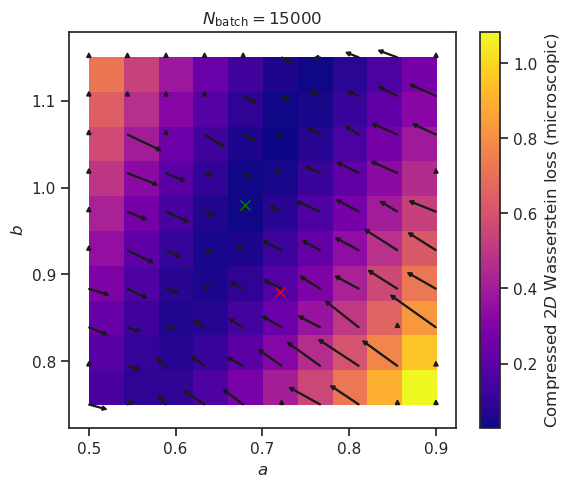

In [29]:
# Set gradient values above a threshold to zero
threshold = 1e2
a_b_gradients[np.abs(a_b_gradients) > threshold] = 0

# Clone a_b_init into numpy array
a_b = a_b_init.detach().numpy()

import matplotlib.colors as mcolors

# Calculate the magnitude of each vector in a_b_gradients
magnitudes = np.linalg.norm(a_b_gradients, axis=1)

fig, ax = plt.subplots(1,1,figsize=(6,5))

# Set the background color based on the magnitude
# Normalize the magnitude to use it with the colormap
norm = mcolors.Normalize(vmin=np.min(magnitudes), vmax=np.max(magnitudes))
cmap = plt.cm.plasma  # Choose a colormap

# Assuming magnitudes can be reshaped into a grid directly for simplicity
# In a real scenario, you might need to interpolate these values onto a grid
grid_shape = (int(np.sqrt(len(magnitudes))), int(np.sqrt(len(magnitudes))))
magnitudes_grid = magnitudes.reshape(grid_shape).T

# Create a heatmap of the gradient magnitudes
#heatmap = ax.imshow(magnitudes_grid, cmap=cmap, norm=norm, origin='lower', extent=(np.min(a_b[:, 0]), np.max(a_b[:, 0]), np.min(a_b[:, 1]), np.max(a_b[:, 1])))
heatmap = ax.imshow(loss_grid.reshape(grid_shape).T, cmap=cmap, origin='lower', extent=(np.min(a_b[:, 0]), np.max(a_b[:, 0]), np.min(a_b[:, 1]), np.max(a_b[:, 1])))

# Add a colorbar to show the magnitude scale
#fig.colorbar(heatmap, ax=ax, label=r'$|\vec{\nabla}_\theta \mathcal{L}|$')
fig.colorbar(heatmap, ax=ax, label=r'Compressed $2D$ Wasserstein loss (microscopic)')

# Plot arrows for each point and direction
for point, gradient in zip(a_b, a_b_gradients):
    ax.arrow(point[0], point[1], -gradient[0]/1e2, -gradient[1]/1e2, head_width=0.005, head_length=0.005, fc='k', ec='k')

a_b_target = np.array([0.68, 0.98]) # Monash
ax.plot(a_b_target[0], a_b_target[1], 'x', color='green', label = 'Target', ms = 7, linewidth=10)#label = r'$\mathrm{Target}$')
ax.plot(ARRG.params_base[0].clone().detach().numpy(), ARRG.params_base[1].clone().detach().numpy(), 'x', color = 'red', label = 'Base', ms = 7, linewidth=10)#label = r'$\mathrm{Base}$'

ax.set_title(rf'$N_{{\mathrm{{batch}}}} = {N_events}$')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')

fig.tight_layout()
fig.savefig('ARRG_flow_micro_compressed_wass2d_loss_Nbatch_15e3.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
fig.savefig('ARRG_flow_micro_compressed_wass2d_loss_Nbatch_15e3.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

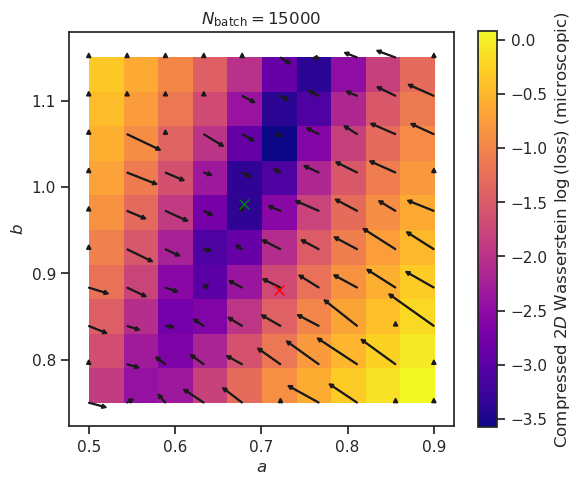

In [31]:
# Set gradient values above a threshold to zero
threshold = 1e2
a_b_gradients[np.abs(a_b_gradients) > threshold] = 0

# Clone a_b_init into numpy array
a_b = a_b_init.detach().numpy()

import matplotlib.colors as mcolors

# Calculate the magnitude of each vector in a_b_gradients
magnitudes = np.linalg.norm(a_b_gradients, axis=1)

fig, ax = plt.subplots(1,1,figsize=(6,5))

# Set the background color based on the magnitude
# Normalize the magnitude to use it with the colormap
norm = mcolors.Normalize(vmin=np.min(magnitudes), vmax=np.max(magnitudes))
cmap = plt.cm.plasma  # Choose a colormap

# Assuming magnitudes can be reshaped into a grid directly for simplicity
# In a real scenario, you might need to interpolate these values onto a grid
grid_shape = (int(np.sqrt(len(magnitudes))), int(np.sqrt(len(magnitudes))))
magnitudes_grid = magnitudes.reshape(grid_shape).T

# Create a heatmap of the gradient magnitudes
#heatmap = ax.imshow(magnitudes_grid, cmap=cmap, norm=norm, origin='lower', extent=(np.min(a_b[:, 0]), np.max(a_b[:, 0]), np.min(a_b[:, 1]), np.max(a_b[:, 1])))
heatmap = ax.imshow((np.log(loss_grid)).reshape(grid_shape).T, cmap=cmap, origin='lower', extent=(np.min(a_b[:, 0]), np.max(a_b[:, 0]), np.min(a_b[:, 1]), np.max(a_b[:, 1])))

# Add a colorbar to show the magnitude scale
#fig.colorbar(heatmap, ax=ax, label=r'$|\vec{\nabla}_\theta \mathcal{L}|$')
fig.colorbar(heatmap, ax=ax, label=r'Compressed $2D$ Wasserstein $\log$(loss) (microscopic)')

# Plot arrows for each point and direction
for point, gradient in zip(a_b, a_b_gradients):
    ax.arrow(point[0], point[1], -gradient[0]/1e2, -gradient[1]/1e2, head_width=0.005, head_length=0.005, fc='k', ec='k')

a_b_target = np.array([0.68, 0.98]) # Monash
ax.plot(a_b_target[0], a_b_target[1], 'x', color='green', label = 'Target', ms = 7, linewidth=10)#label = r'$\mathrm{Target}$')
ax.plot(ARRG.params_base[0].clone().detach().numpy(), ARRG.params_base[1].clone().detach().numpy(), 'x', color = 'red', label = 'Base', ms = 7, linewidth=10)#label = r'$\mathrm{Base}$'

ax.set_title(rf'$N_{{\mathrm{{batch}}}} = {N_events}$')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')

fig.tight_layout()
fig.savefig('ARRG_flow_micro_compressed_wass2d_loss_log_Nbatch_15e3.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
fig.savefig('ARRG_flow_micro_compressed_wass2d_loss_log_Nbatch_15e3.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [32]:
# Save the (a,b) values, their gradients, and the loss grid
np.save('flow_data/flow_data_compressed_wass2d_a_b_Nbatch_25e3_fixed.npy', a_b)
np.save('flow_data/flow_data_compressed_wass2d_a_b_gradients_Nbatch_25e3_fixed.npy', a_b_gradients)
np.save('flow_data/flow_data_compressed_wass2d_losses_Nbatch_25e3_fixed.npy', loss_grid)

In [ ]:
# Loading previous flow map
a_b = np.load('flow_data/flow_data_a_b_Nbatch_5e3.npy')
a_b_gradients = np.load('flow_data/flow_data_a_b_gradients_Nbatch_5e3.npy')
loss_grid = np.load('flow_data/flow_data_losses_Nbatch_5e3.npy')